**Author:** Manuel Hernandez Alonso, niub20274855

In [1]:
!pip install -U scikit-learn
!pip install autograd

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 21.2 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2


## Preliminary: the softmax function

The softmax function plays a crucial role in neural networks, particularly in the output layer of classification models. Its primary purpose is to convert a vector of real numbers into a probability distribution over multiple classes.

$$\text{Softmax}(z_i) = \frac{e^{z_{i}}}{\sum_{j=1}^K e^{z_{j}}} \ \ \ for\ i=1,2,\dots,K
 $$

First, each element of the input vector is exponentiated (raised to the power of $e$), which makes all values positive.  The exponentiation step amplifies the differences between the input values. Larger values get significantly larger, and smaller values remain relatively small. This emphasizes the model's confidence in its predictions.

After exponentiation, the softmax function normalizes the values by dividing each exponentiated value by the sum of all exponentiated values in the input vector. This step ensures that the output vector sums up to 1, making it a valid probability distribution.

# 1st Assignment: NN's from Scratch

The objective is to build from scratch a neural network to perform  classification. Let's firt consider the following 2-class dataset:

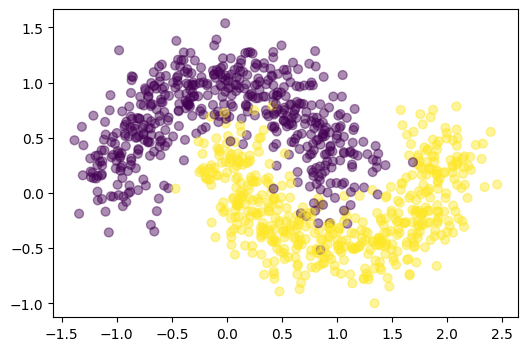

In [2]:
import matplotlib.pyplot as plt
import sklearn
import sklearn.datasets
import sklearn.linear_model
import matplotlib
import autograd.numpy as np
from autograd import grad
from autograd.misc import flatten

# Display plots inline and change default figure size
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (6.0, 4.0)

# Generate a training dataset and plot it
np.random.seed(0)
X, y = sklearn.datasets.make_moons(1000, noise=0.20)
plt.scatter(X[:,0], X[:,1], s=40, c=y, alpha=0.45)

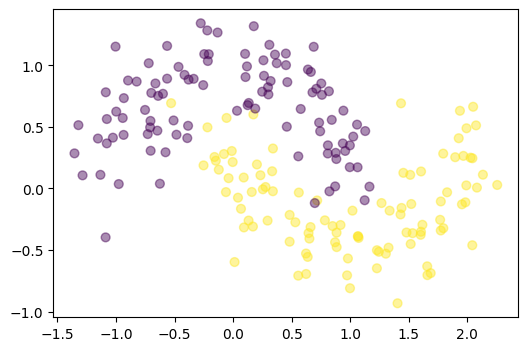

In [3]:
# Generate a testing dataset and plot it
np.random.seed(0)
Xt, yt = sklearn.datasets.make_moons(200, noise=0.20)
plt.scatter(Xt[:,0], Xt[:,1], s=40, c=yt, alpha=0.45)

In [4]:
X[1], X.shape

(array([1.80460944, 0.00695963]), (1000, 2))

In [5]:
y[1], y.shape

(1, (1000,))

## Classification

We will use a **3-layer classification neural network** with one input layer, one hidden layer, and one output layer.

+ The number of nodes in the input layer will be determined by the dimensionality of our data (2).
+ Similarly, the number of nodes in the output layer is determined by the number of classes $C$ we have (also 2).

If $x$ is the input to our network then we calculate our prediction $\hat{y}$ as follows:

$$ z_1 = x W_1 + b_1 $$
$$ a_1 = \sigma(z_1) $$
$$ z_2 = a_1 W_2 + b_2$$
$$ \hat{y} = \text{Softmax}({z_2})$$

where $\hat{y}$ is a multidimensional vector representing a probability distribution over classes, $\sigma$ is a non linear function and $W_1, b_1, W_2, b_2$ are parameters of our network, which we need to learn from our training data. You can think of the parameters $W$ as matrices transforming data between layers of the network.

Looking at the matrix multiplications above we can figure out the dimensionality of these matrices in our problem. If we use 500 nodes for our hidden layer then $W_1 \in \mathbb{R}^{2\times500}$, $b_1 \in \mathbb{R}^{500}$, $W_2 \in \mathbb{R}^{500\times2}$, $b_2 \in \mathbb{R}^{2}$.


## Cross-entropy loss

A common choice with the softmax output is the **cross-entropy loss**.

If we have $N$ training examples in our minibatch dataset and $C$ classes, then the loss for our prediction $\hat{y}$ for that minibatch with respect to the true labels $y$ is given by:

$$
\begin{aligned}
L(y,\hat{y}) = - \frac{1}{N} \sum_{n \in N} \sum_{i \in C} y_{n,i} \log\hat{y}_{n,i}
\end{aligned}
$$

Let's now define some general parameters:

In [6]:
num_examples = len(X) # training set size
nn_input_dim = 2 # input layer dimensionality
nn_output_dim = 2 # output layer dimensionality
sigma = np.tanh # activation function

# Gradient descent parameters
epsilon = 0.01 # learning rate for gradient descent

In [7]:
# loss function for a 3-layer MLP
def loss(model):
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']

    # Forward propagation to calculate our predictions
    z1 = np.dot(X,W1) + b1
    a1 = sigma(z1)
    z2 = np.dot(a1,W2) + b2
    exp_scores = np.exp(z2)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

    # Calculating the loss
    corect_logprobs = -np.log(probs[range(num_examples), y])
    data_loss = np.sum(corect_logprobs)

    return 1./num_examples * data_loss

# forward propagation
def predict(model, x):
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    z1 = np.dot(x,W1) + b1
    a1 = sigma(z1)
    z2 = np.dot(a1,W2) + b2
    exp_scores = np.exp(z2)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    return np.argmax(probs, axis=1)

In [8]:
# This function learns parameters for the neural network and returns the model.
# - nn_hdim: Number of nodes in the hidden layer
# - num_passes: Number of passes through the training data for gradient descent
# - print_loss: If True, print the loss every 1000 iterations

def build_model(nn_hdim, num_passes=50000, print_loss=False):

    # Initialize the parameters to random values.
    np.random.seed(0)
    W1 = np.random.randn(nn_input_dim, nn_hdim) / np.sqrt(nn_input_dim)
    b1 = np.zeros((1, nn_hdim))
    W2 = np.random.randn(nn_hdim, nn_output_dim) / np.sqrt(nn_hdim)
    b2 = np.zeros((1, nn_output_dim))

    # This is what we return at the end
    model = { 'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}

    # Gradient descent. For each batch...
    for i in range(0, num_passes):

        # Forward propagation
        predict(model, X)

        # computing the derivative by AD
        gradient_loss = grad(loss)

        # flattening nested containers containing numpy arrays
        # Returns 1D numpy array and an unflatten function.
        model_flat, unflatten_m = flatten(model)
        grad_flat, unflatten_g = flatten(gradient_loss(model))

        # gradient descend
        model_flat -= grad_flat * epsilon
        model = unflatten_m(model_flat)

        # Optionally print the loss.
        # This is expensive because it uses the whole dataset, so we don't want to do it too often.
        if print_loss and i % 1000 == 0:
            print("Loss after iteration %i: %f" %(i, loss(model)))

    return model

# Build a model with a 3-dimensional hidden layer
model = build_model(3, print_loss=True)

Loss after iteration 0: 0.578993
Loss after iteration 1000: 0.318070
Loss after iteration 2000: 0.297688
Loss after iteration 3000: 0.292829
Loss after iteration 4000: 0.289559
Loss after iteration 5000: 0.286088
Loss after iteration 6000: 0.281947
Loss after iteration 7000: 0.276860
Loss after iteration 8000: 0.270635
Loss after iteration 9000: 0.263206
Loss after iteration 10000: 0.254674
Loss after iteration 11000: 0.245306
Loss after iteration 12000: 0.235476
Loss after iteration 13000: 0.225571
Loss after iteration 14000: 0.215925
Loss after iteration 15000: 0.206780
Loss after iteration 16000: 0.198287
Loss after iteration 17000: 0.190518
Loss after iteration 18000: 0.183483
Loss after iteration 19000: 0.177156
Loss after iteration 20000: 0.171486
Loss after iteration 21000: 0.166413
Loss after iteration 22000: 0.161872
Loss after iteration 23000: 0.157801
Loss after iteration 24000: 0.154141
Loss after iteration 25000: 0.150836
Loss after iteration 26000: 0.147835
Loss after ite

Text(0.5, 1.0, 'Decision Boundary for hidden layer size 3')

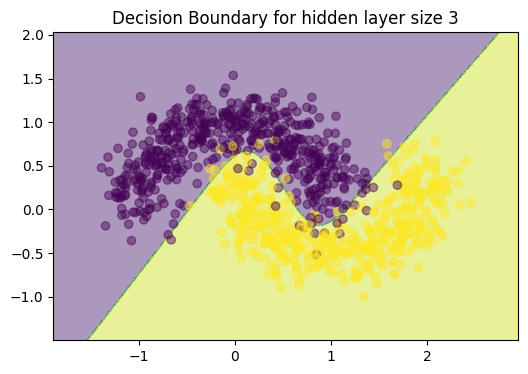

In [9]:
def plot_decision_boundary(pred_func):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, alpha=0.45)
    plt.scatter(X[:, 0], X[:, 1], c=y, alpha=0.45)


# Plot the decision boundary
plot_decision_boundary(lambda x: predict(model, x))
plt.title("Decision Boundary for hidden layer size 3")

# Exercise 1

+ Report the classification accuracy using the testing dataset.

In [10]:
def accuracy_score(y, yhat):
  """
  Function that returns the accuracy of the model based on the predictions (yhat) and the real values (yhat)

  acc = (correct predictions)/(number of predictions)
  """
  return sum([1 for pr, rl in zip(yhat, y) if pr == rl])/len(yhat)

yhat = predict(model, Xt)
print(accuracy_score(yt, yhat))

0.955


# Exercise 2

+ Add an additional layer to your neural network model.
+ Change the activation function and use a ReLU.


Firstly I modified the activation function sigma as a ReLU, where it takes the maximum between 0.0 and x as the activation. Then I added the extra fully connected layer with weight W3 and bias b3.

In [11]:
# Function to calculate forward propagation of a 4-layer MLP
def _forward(ins, model):
  W1, b1, W2, b2, W3, b3 = model['W1'], model['b1'], model['W2'], model['b2'], model['W3'], model['b3']

  z1 = np.dot(ins,W1) + b1
  a1 = sigma(z1)
  z2 = np.dot(a1,W2) + b2
  a2 = sigma(z2)
  z3 = np.dot(a2, W3) + b3
  exp_scores = np.exp(z3)
  probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
  return probs

# loss function for a 3-layer MLP
def loss(model):

  # Forward propagation to calculate our predictions
  probs = _forward(X, model)

  # Calculating the loss
  corect_logprobs = -np.log(probs[range(num_examples), y])
  data_loss = np.sum(corect_logprobs)

  return 1./num_examples * data_loss

# forward propagation
def predict(model, x):
  probs = _forward(x, model)
  return np.argmax(probs, axis=1)

# This function learns parameters for the neural network and returns the model.
# - nn_hdim: Number of nodes in the hidden layer
# - num_passes: Number of passes through the training data for gradient descent
# - print_loss: If True, print the loss every 1000 iterations

def build_model(nn_hdim, num_passes=50000, print_loss=False):

  # Initialize the parameters to random values.
  np.random.seed(0)
  W1 = np.random.randn(nn_input_dim, nn_hdim) / np.sqrt(nn_input_dim)
  b1 = np.zeros((1, nn_hdim))
  W2 = np.random.randn(nn_hdim, nn_hdim) / np.sqrt(nn_hdim)
  b2 = np.zeros((1, nn_hdim))
  W3 = np.random.randn(nn_hdim, nn_output_dim) / np.sqrt(nn_hdim)
  b3 = np.zeros((1, nn_output_dim))

  # This is what we return at the end
  model = { 'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2, 'W3': W3, 'b3': b3}

  # Gradient descent. For each batch...
  for i in range(0, num_passes):

    # Forward propagation
    predict(model, X)

    # computing the derivative by AD
    gradient_loss = grad(loss)

    # flattening nested containers containing numpy arrays
    # Returns 1D numpy array and an unflatten function.
    model_flat, unflatten_m = flatten(model)
    grad_flat, unflatten_g = flatten(gradient_loss(model))

    # gradient descend
    model_flat -= grad_flat * epsilon
    model = unflatten_m(model_flat)

    # Optionally print the loss.
    # This is expensive because it uses the whole dataset, so we don't want to do it too often.
    if print_loss and i % 1000 == 0:
      print("Loss after iteration %i: %f" %(i, loss(model)))

  return model

In [12]:
sigma = lambda x: np.maximum(0.0, x) # ReLU activation function
# Build a model with a 3-dimensional hidden layer
model = build_model(3, print_loss=True)

Loss after iteration 0: 0.608797
Loss after iteration 1000: 0.311775
Loss after iteration 2000: 0.298420
Loss after iteration 3000: 0.288472
Loss after iteration 4000: 0.282411
Loss after iteration 5000: 0.278174
Loss after iteration 6000: 0.274442
Loss after iteration 7000: 0.271007
Loss after iteration 8000: 0.267987
Loss after iteration 9000: 0.265382
Loss after iteration 10000: 0.263243
Loss after iteration 11000: 0.261471
Loss after iteration 12000: 0.259814
Loss after iteration 13000: 0.258426
Loss after iteration 14000: 0.257259
Loss after iteration 15000: 0.256271
Loss after iteration 16000: 0.255432
Loss after iteration 17000: 0.254715
Loss after iteration 18000: 0.254071
Loss after iteration 19000: 0.253494
Loss after iteration 20000: 0.252974
Loss after iteration 21000: 0.252542
Loss after iteration 22000: 0.252180
Loss after iteration 23000: 0.251862
Loss after iteration 24000: 0.251596
Loss after iteration 25000: 0.251372
Loss after iteration 26000: 0.251171
Loss after ite

In [13]:
yhat = predict(model, Xt) # Calculate the predictions
print(accuracy_score(yt, yhat)) # Calculate the accuracy

0.875


# Exercise 3

+ Design your own model (layers, activation function, number of units per layer, etc.) and train it to classify the following dataset.
+ Train the model and report the classification accuracy using the testing dataset.


In [14]:
# Function to calculate forward propagation of a 7-layer MLP
def _forward(ins, model):
  W1, b1, W2, b2, W3, b3, W4, b4, W5, b5, W6, b6 = model['W1'], model['b1'], model['W2'], model['b2'], model['W3'], model['b3'], model['W4'], model['b4'], model['W5'], model['b5'], model['W6'], model['b6']

  z1 = np.dot(ins,W1) + b1
  a1 = sigma(z1)
  z2 = np.dot(a1,W2) + b2
  a2 = sigma(z2)
  z3 = np.dot(a2, W3) + b3
  a3 = sigma(z3)
  z4 = np.dot(a3, W4) + b4
  a4 = sigma(z4)
  z5 = np.dot(a4, W5) + b5
  a5 = sigma(z5)
  z6 = np.dot(a5, W6) + b6
  exp_scores = np.exp(z6)
  probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
  return probs

# loss function for a 7-layer MLP
def loss(model):

  # Forward propagation to calculate our predictions
  probs = _forward(X, model)

  # Calculating the loss
  corect_logprobs = -np.log(probs[range(num_examples), y])
  data_loss = np.sum(corect_logprobs)

  return 1./num_examples * data_loss

# forward propagation
def predict(model, x):
  probs = _forward(x, model)
  return np.argmax(probs, axis=1)

# This function learns parameters for the neural network and returns the model.
# - nn_hdim: Number of nodes in the hidden layer
# - num_passes: Number of passes through the training data for gradient descent
# - print_loss: If True, print the loss every 1000 iterations

def build_model(nn_hdim, num_passes=50000, print_loss=False):

  # Initialize the parameters to random values.
  np.random.seed(0)
  W1 = np.random.randn(nn_input_dim, nn_hdim) / np.sqrt(nn_input_dim)
  b1 = np.zeros((1, nn_hdim))
  W2 = np.random.randn(nn_hdim, nn_hdim) / np.sqrt(nn_hdim)
  b2 = np.zeros((1, nn_hdim))
  W3 = np.random.randn(nn_hdim, nn_hdim) / np.sqrt(nn_hdim)
  b3 = np.zeros((1, nn_hdim))
  W4 = np.random.randn(nn_hdim, nn_hdim) / np.sqrt(nn_hdim)
  b4 = np.zeros((1, nn_hdim))
  W5 = np.random.randn(nn_hdim, nn_hdim) / np.sqrt(nn_hdim)
  b5 = np.zeros((1, nn_hdim))
  W6 = np.random.randn(nn_hdim, nn_output_dim) / np.sqrt(nn_hdim)
  b6 = np.zeros((1, nn_output_dim))

  # This is what we return at the end
  model = { 'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2, 'W3': W3, 'b3': b3, 'W4': W4, 'b4': b4, 'W5': W5, 'b5': b5, 'W6': W6, 'b6': b6}
  # Gradient descent. For each batch...
  for i in range(0, num_passes):

    # Forward propagation
    predict(model, X)

    # computing the derivative by AD
    gradient_loss = grad(loss)

    # flattening nested containers containing numpy arrays
    # Returns 1D numpy array and an unflatten function.
    model_flat, unflatten_m = flatten(model)
    grad_flat, unflatten_g = flatten(gradient_loss(model))

    # gradient descend
    model_flat -= grad_flat * epsilon
    model = unflatten_m(model_flat)

    # Optionally print the loss.
    # This is expensive because it uses the whole dataset, so we don't want to do it too often.
    if print_loss and i % 1000 == 0:
      print("Loss after iteration %i: %f" %(i, loss(model)))

  return model

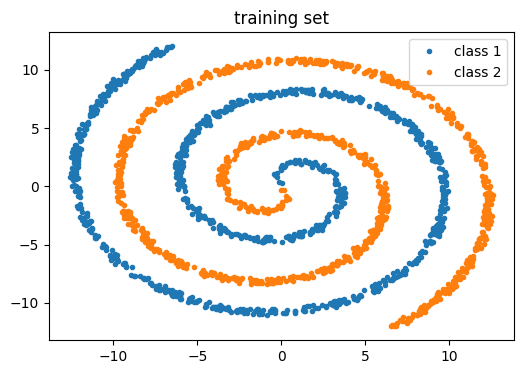

In [15]:
import matplotlib.pyplot as plt
import autograd.numpy as np

def twospirals(n_points, noise=.5):
    """
     Returns the two spirals dataset.
    """
    n = np.sqrt(np.random.rand(n_points,1)) * 780 * (2*np.pi)/360
    d1x = -np.cos(n)*n + np.random.rand(n_points,1) * noise
    d1y = np.sin(n)*n + np.random.rand(n_points,1) * noise
    return (np.vstack((np.hstack((d1x,d1y)),np.hstack((-d1x,-d1y)))),
            np.hstack((np.zeros(n_points),np.ones(n_points))).astype(int))

X, y = twospirals(1000)

plt.title('training set')
plt.plot(X[y==0,0], X[y==0,1], '.', label='class 1')
plt.plot(X[y==1,0], X[y==1,1], '.', label='class 2')
plt.legend()
plt.show()

In [19]:
num_examples = len(X) # training set size
nn_input_dim = 2 # input layer dimensionality
nn_output_dim = 2 # output layer dimensionality
sigma = lambda c: np.maximum(0.01, c) # Use the pReLU as activation function

# Gradient descent parameters
epsilon = 0.01 # learning rate for gradient descent

In [21]:

# Here I built a model with 10 dimensions of hidden layer, with 7 layers
mdl = build_model(10, print_loss=True)

Loss after iteration 0: 0.712439
Loss after iteration 1000: 0.658972
Loss after iteration 2000: 0.647383
Loss after iteration 3000: 0.638700
Loss after iteration 4000: 0.631337
Loss after iteration 5000: 0.625521
Loss after iteration 6000: 0.622116
Loss after iteration 7000: 0.621652
Loss after iteration 8000: 0.618562
Loss after iteration 9000: 0.615394
Loss after iteration 10000: 0.610619
Loss after iteration 11000: 0.605375
Loss after iteration 12000: 0.598080
Loss after iteration 13000: 0.589691
Loss after iteration 14000: 0.571992
Loss after iteration 15000: 0.526983
Loss after iteration 16000: 0.472936
Loss after iteration 17000: 0.389852
Loss after iteration 18000: 0.359054
Loss after iteration 19000: 0.326233
Loss after iteration 20000: 0.272294
Loss after iteration 21000: 0.182958
Loss after iteration 22000: 0.620983
Loss after iteration 23000: 0.067604
Loss after iteration 24000: 0.019069
Loss after iteration 25000: 0.009300
Loss after iteration 26000: 0.005721
Loss after ite

Text(0.5, 1.0, 'Decision Boundary for hidden layer size 10')

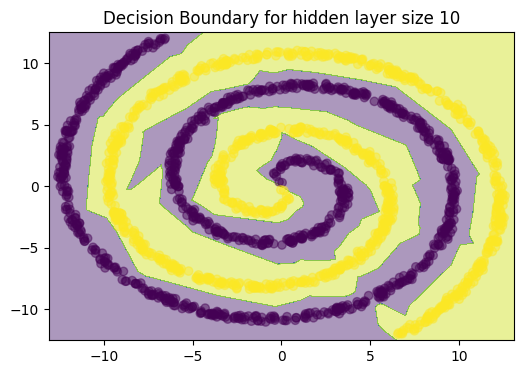

In [23]:
def plot_decision_boundary(pred_func):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, alpha=0.45)
    plt.scatter(X[:, 0], X[:, 1], c=y, alpha=0.45)


# Plot the decision boundary
plot_decision_boundary(lambda x: predict(mdl, x))
plt.title("Decision Boundary for hidden layer size 10")